### Autoregressive Integrated Moving Average
https://otexts.com/fpp2/stationarity.html<br>
A statistical model is autoregressive if it predicts future values based on past values

<ul>
<li>ARIMA models predict future values based on past values.
<li>ARIMA makes use of lagged moving averages to smooth time series data.
<li>Autoregressive models implicitly assume that the future will resemble the past.
<li>Therefore, they can prove inaccurate under certain market conditions, such as financial crises or periods of rapid technological change.
</ul>

<i>An autoregressive integrated moving average model is a form of regression analysis that gauges the strength of one dependent variable relative to other changing variables. The model's goal is to predict future securities or financial market moves by examining the differences between values in the series instead of through actual values.</i>

<ol><li>Autoregression (AR): refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.
<li>Integrated (I): represents the differencing of raw observations to allow for the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).
<li>Moving average (MA):  incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.
</ol>

<i>In an autoregressive integrated moving average model, the data are differenced in order to make it stationary. A model that shows stationarity is one that shows there is constancy to the data over time. Most economic and market data show trends, so the purpose of differencing is to remove any trends or seasonal structures.</i> 

<i>Seasonality, or when data show regular and predictable patterns that repeat over a calendar year, could negatively affect the regression model. If a trend appears and stationarity is not evident, many of the computations throughout the process cannot be made with great efficacy.<i>
    
<b>ARIMA combines autoregressive features with those of moving averages. An AR(1) autoregressive process, for instance, is one in which the current value is based on the immediately preceding value, while an AR(2) process is one in which the current value is based on the previous two values. A moving average is a calculation used to analyze data points by creating a series of averages of different subsets of the full data set in order to smooth out the influence of outliers. As a result of this combination of techniques, ARIMA models can take into account trends, cycles, seasonality, and other non-static types of data when making forecasts.</b>

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib
plt.rcParams['axes.grid'] = True
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["figure.figsize"] = (10,6)
#matplotlib.rcParams["legend.framealpha"] = 1
#matplotlib.rcParams["legend.frameon"] = True

In [17]:
# dataframe info
def info(df, first=5, c=1):
    if c: print(list(df.columns))
    print('DF Shape: ',df.shape)
    return df.head(first)

In [3]:
data = pd.read_csv('AirPassengers.csv')

In [4]:
info(data)

['Month', '#Passengers']
DF Shape:  (144, 2)


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [97]:
# convert date into pandas DateTime format, rename columns

data['Month'] = pd.to_datetime(data['Month'])
df = data.rename(columns={'Month':'date','#Passengers':'count'})
info(df)

['date', 'count']
DF Shape:  (144, 2)


,date,count
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [98]:
# set date as index

df.set_index(df['date'], inplace=True)
df.drop('date', axis=1, inplace=True)
info(df)

['count']
DF Shape:  (144, 1)


,count
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [99]:
print(df.iloc[144-1])

count    432
Name: 1960-12-01 00:00:00, dtype: int64


<AxesSubplot:title={'center':'Frequency to 1 Year'}, xlabel='date'>

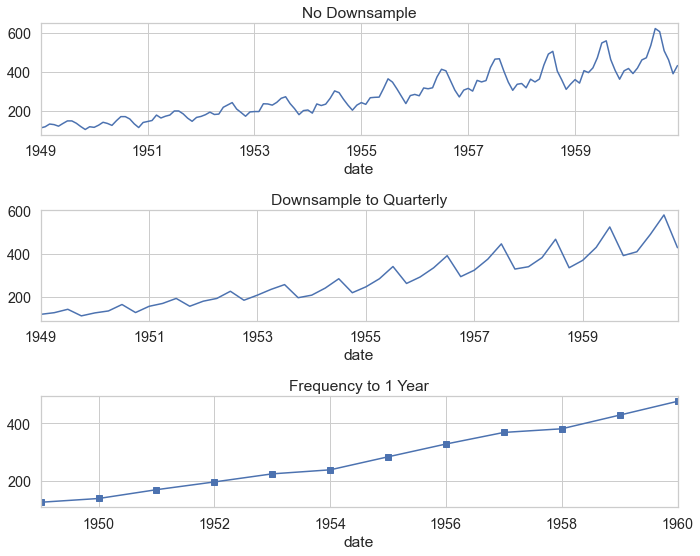

In [100]:
# downsampled plots

fig, ax = plt.subplots(3,1, layout='tight', figsize=(10,8))

df.plot(ax=ax[0], legend=False, title='No Downsample')
df.resample('Q').mean().plot(ax=ax[1], legend=False, title='Downsample to Quarterly')
df.resample('Y').mean().plot(ax=ax[2], legend=False, title='Frequency to 1 Year', marker='s')

In [101]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

def plot_rmean_rstd(df, window=12):
    
    #Determine rolling statistics
    RollAvg = df.rolling(window=window).mean()
    RollStd = df.rolling(window=window).std()
    
    #Plot rolling statistics
    fig, ax = plt.subplots()
    ax.plot(df, color='lightgray', label='Data')
    ax.plot(RollAvg, color='navy', label='Rolling Average')
    ax.plot(RollStd, color='red', label='Rolling Std')
    plt.legend()
    plt.show(block=False)
     
    # try:
    # Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    airpass_test = adfuller(df['count'], autolag='AIC')
    dfoutput = pd.Series(airpass_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in airpass_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    # except Exception as e:
    #     print(e)

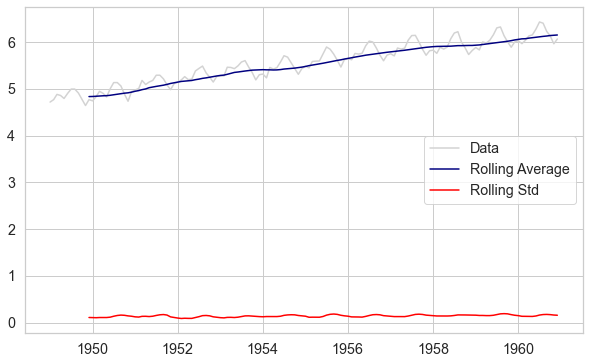

Results of Dickey Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [102]:
# log transformation to stabilize standard deviation

df_log = np.log(df)
plot_rmean_rstd(df_log)

(132, 1)


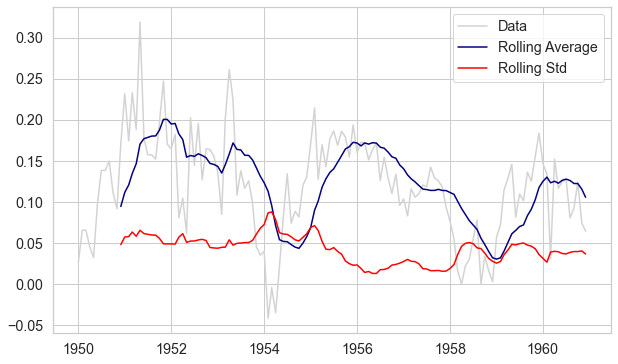

Results of Dickey Fuller Test:
Test Statistic                  -2.709577
p-value                          0.072396
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [103]:
# Differencing with order of 12 to remove effect of seasonality and stabalize mean

# need to use dropna here because 12th order differencing returns n-12 = 144-12 = 132 non null values or 12 null values
df_diff=df_log.diff(periods=12).dropna()
print(df_diff.shape)
# same as -> df_log_diff = df_log - df_log.shift()
plot_rmean_rstd(df_diff)

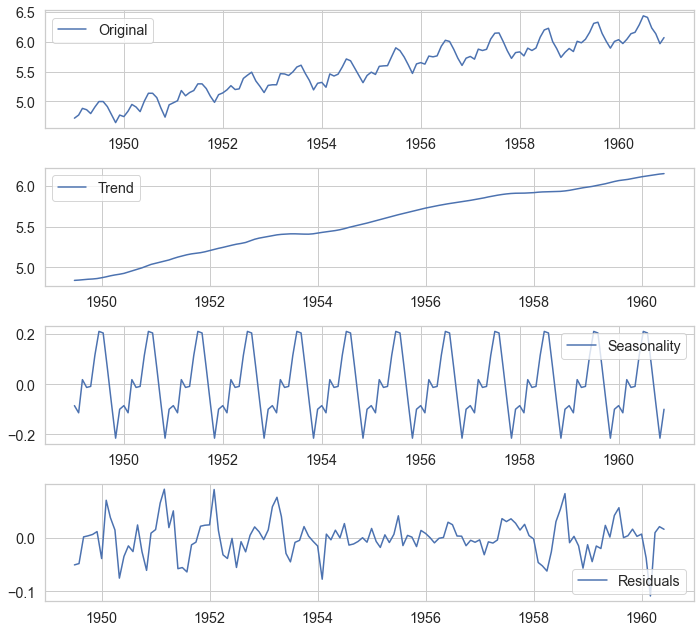

In [104]:
# removing seasonality
decomposition = seasonal_decompose(df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(4,1,figsize=(10,9), layout='tight')
ax[0].plot(df_log, label='Original')
ax[0].legend()

ax[1].plot(trend, label='Trend')
ax[1].legend()

ax[2].plot(seasonal,label='Seasonality')
ax[2].legend()

ax[3].plot(residual, label='Residuals')
ax[3].legend()
plt.show()

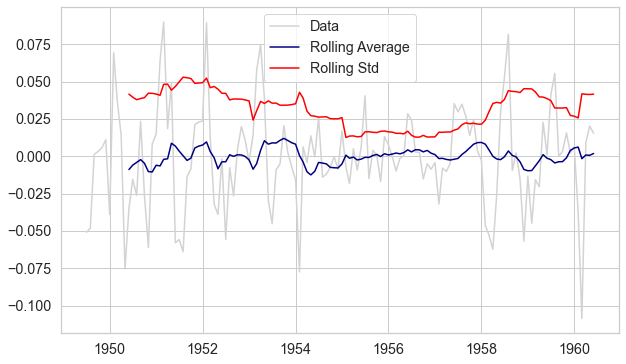

Results of Dickey Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [105]:
df_res = residual.to_frame('count').dropna()
plot_rmean_rstd(df_res)

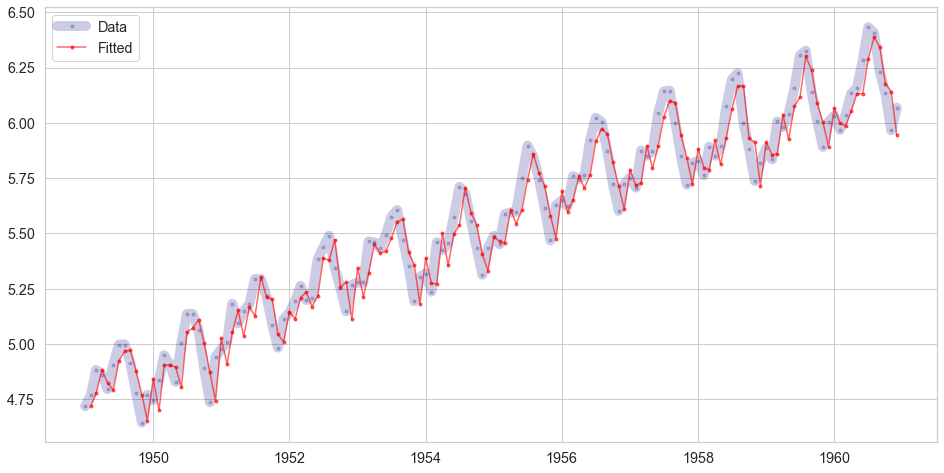

In [133]:
import statsmodels.api as sm

# decomposition = seasonal_decompose(df_log) 
model = sm.tsa.arima.ARIMA(df_log, order=(2,1,2))
# model = ARIMA(df_log, order=(2,1,2))
results = model.fit()
plt.figure(figsize=(16,8))
plt.plot(df_log, label='Data', alpha=0.2, color='navy', linewidth='10', marker='.')
plt.plot(results.fittedvalues[1:], alpha=0.6, color='red', label='Fitted', marker='.')
plt.legend()
plt.show()

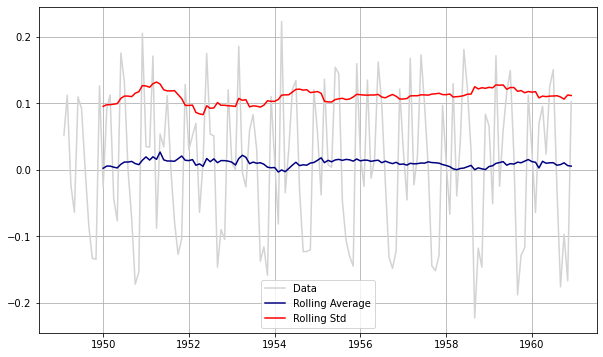

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
df_diff=df_log.diff().dropna()
# same as -> df_log_diff = df_log - df_log.shift()
plot_rmean_rstd(df_diff)

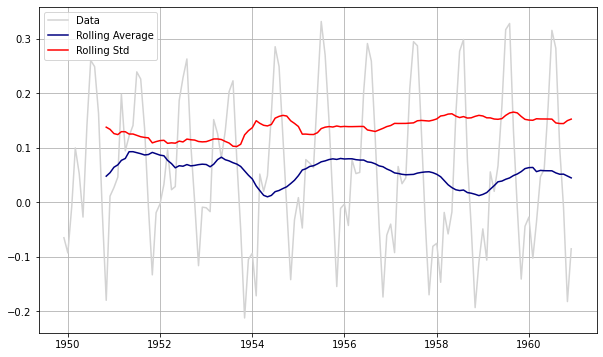

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [ ]:
rollmean_log = df_log.rolling(window=12).mean()
# rollstd_log = df_log.rolling(window=12).std()
df_new = df_log - rollmean_log
df_new.dropna(inplace=True)
plot_rmean_rstd(df_new)

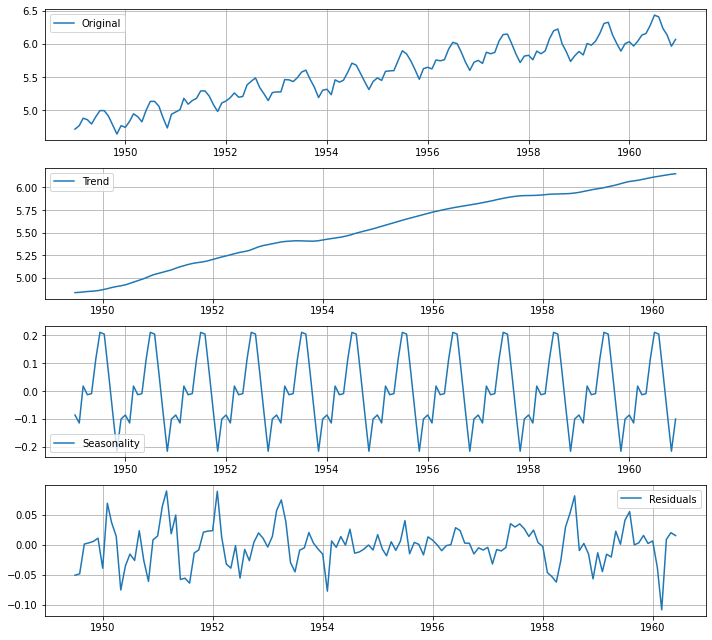

In [39]:
# removing seasonality
decomposition = seasonal_decompose(df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(4,1,figsize=(10,9), layout='tight')
ax[0].plot(df_log, label='Original')
ax[0].legend()

ax[1].plot(trend, label='Trend')
ax[1].legend()

ax[2].plot(seasonal,label='Seasonality')
ax[2].legend()

ax[3].plot(residual, label='Residuals')
ax[3].legend()
plt.show()

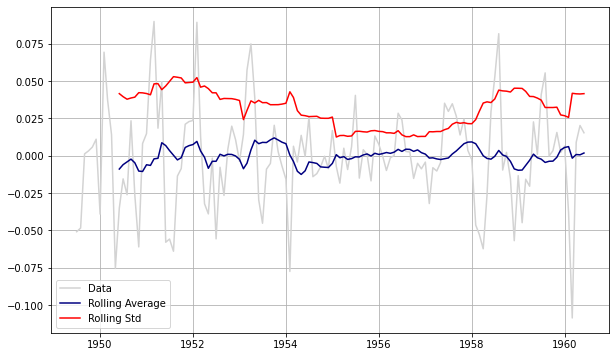

Results of Dickey Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [67]:
df_res = residual.to_frame('count').dropna()
plot_rmean_rstd(df_res)

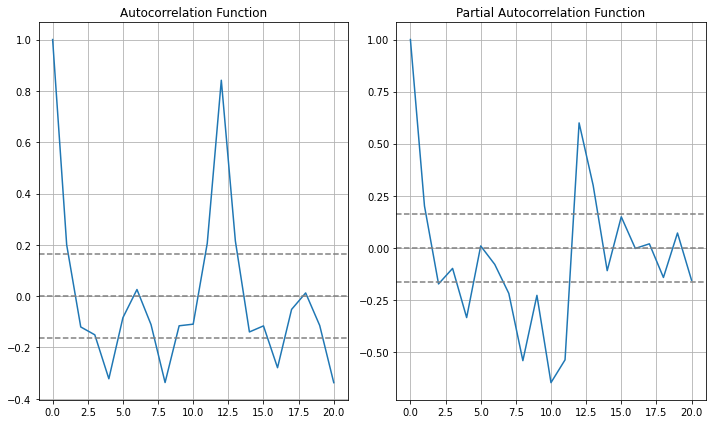

In [71]:
lag_acf = acf(df_diff, nlags=20)
lag_pacf = pacf(df_diff, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

From the ACF graph, we can see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower the RSS values indicates a better model.

i.e order=(2,1,0)

>p = order of AR term<br>
>d = order of differencing in-order to make timeseries stationary<br>
>q = order of MA term

/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


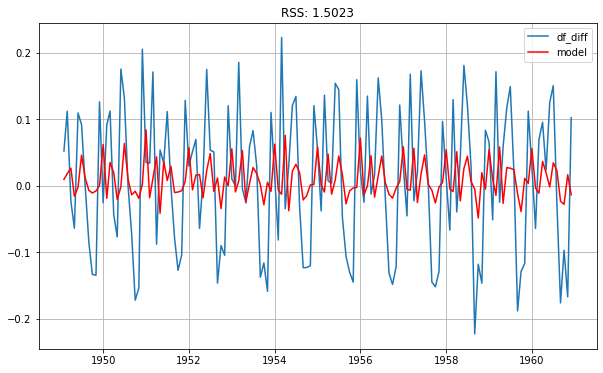

In [100]:
import statsmodels.api as smapi
model1 = smapi.tsa.arima.ARIMA(df_diff, order=(2,0,0))

# model1 = ARIMA(df_log, order=(2,1,0))
results_AR = model1.fit()
plt.plot(df_diff, label='df_diff')
plt.plot(results_AR.fittedvalues, color='red', label='model')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_diff['count'])**2))
plt.legend()

/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


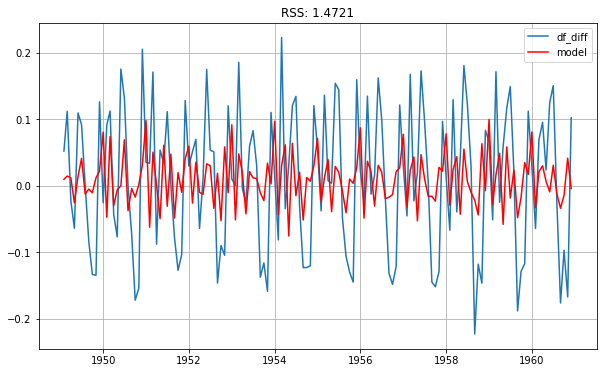

In [103]:
import statsmodels.api as smapi
model1 = smapi.tsa.arima.ARIMA(df_diff, order=(0,0,2))

# model1 = ARIMA(df_log, order=(2,1,0))
results_AR = model1.fit()
plt.plot(df_diff, label='df_diff')
plt.plot(results_AR.fittedvalues, color='red', label='model')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_diff['count'])**2))
plt.legend()

/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rushank/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


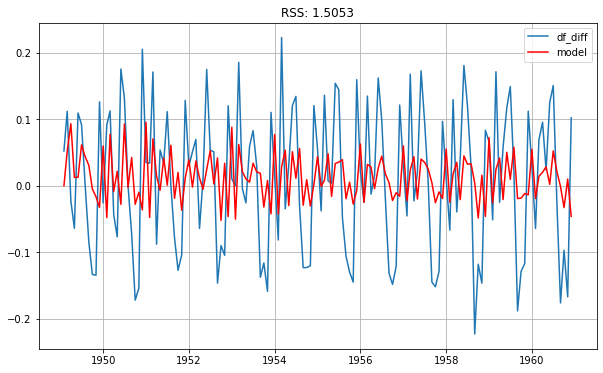

In [115]:
import statsmodels.api as smapi
model1 = smapi.tsa.arima.ARIMA(df_diff, order=(2,1,2))

# model1 = ARIMA(df_log, order=(2,1,0))
results_AR = model1.fit()
plt.plot(df_diff, label='df_diff')
plt.plot(results_AR.fittedvalues, color='red', label='model')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_diff['count'])**2))
plt.legend()

In [171]:
x = set([1,2])
x.discard(1)

In [178]:
list(x)[0]

2